In [1]:
import sys
sys.path.append('libsigma')


In [2]:
def report_from_dict_to_df(dict_report):


    # convert report into dataframe
    report_df = pd.DataFrame.from_dict(dict_report)

    # drop unnecessary rows and columns
    try :
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    except KeyError:
        print(dict_report)
        report_df = report_df.drop(['micro avg', 'macro avg', 'weighted avg'], axis=1)

    report_df = report_df.drop(['support'], axis=0)

    return report_df


In [15]:

isinstance(3.9, float)

True

/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


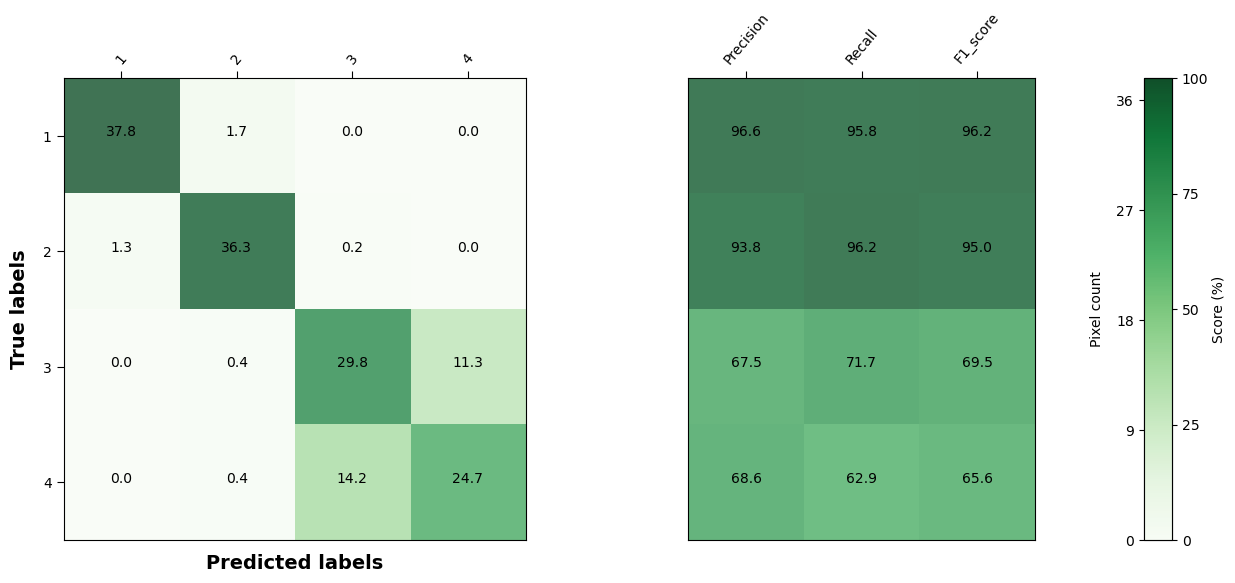

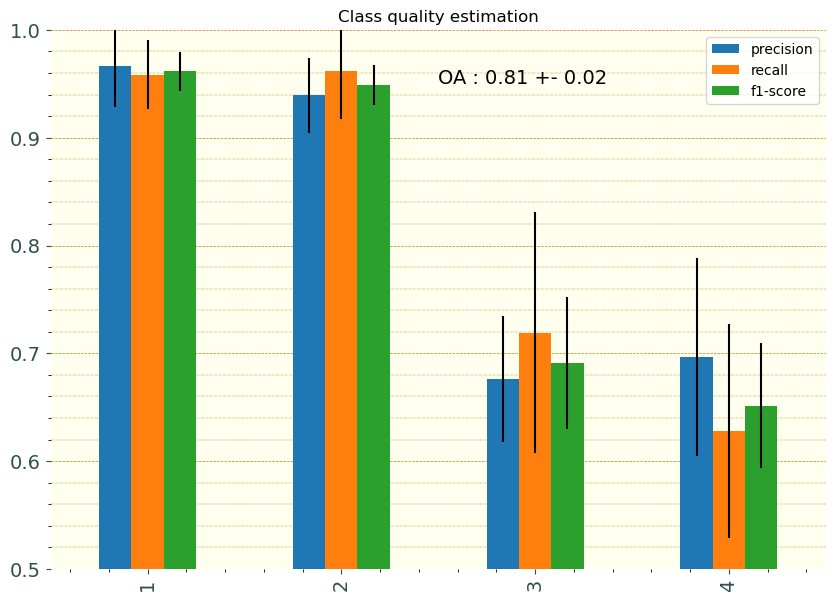

In [3]:
import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = '/home/onyxia/work/data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.3
nb_iter = 30
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_SplitTest{}Train{}_x{}times'.format(test_size, 1-test_size, nb_iter)
out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))

# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

for i in range(nb_iter):  
    # Split sample
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)
    # store them
    list_report.append(report_from_dict_to_df(report))


# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')


# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

## Croisée et stratifiée

In [4]:
import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = '/home/onyxia/work/data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}fold_group_x{}times'.format(nb_folds, nb_iter)
out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
for _ in range(nb_iter) :
  kf = GroupKFold(n_splits=nb_folds)
  for train, test in kf.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]

      # 3 --- Train
      #clf = SVC(cache_size=6000)
      clf = tree.DecisionTreeClassifier()
      clf.fit(X_train, Y_train)

      # 4 --- Test
      Y_predict = clf.predict(X_test)

      # compute quality
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_predict),
                                     output_dict=True)

      # store them
      list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

ValueError: object too deep for desired array

## Validation croisée/stratifié en prenant en compte les groupes

In [5]:


import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = '/home/onyxia/work/data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}folds_stratified_group_x{}times'.format(nb_folds, nb_iter)
out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
for _ in range(nb_iter):
  kf = StratifiedGroupKFold(n_splits=nb_folds, shuffle=True)
  for train, test in kf.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]

      # 3 --- Train
      #clf = SVC(cache_size=6000)
      clf = tree.DecisionTreeClassifier()
      clf.fit(X_train, Y_train)

      # 4 --- Test
      Y_predict = clf.predict(X_test)

      # compute quality
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_predict),
                                     output_dict=True)

      # store them
      list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

TypeError: unhashable type: 'numpy.ndarray'

In [6]:
train

NameError: name 'train' is not defined

In [10]:
for train, test in kf.split(X, Y, groups=list(groups)):
    print("%s %s" % (train, test))

TypeError: unhashable type: 'numpy.ndarray'